In [1]:
from __future__ import division
#from sympy import *
import numpy as np
from numpy.linalg import *
import time
import matplotlib.pyplot as plt
%matplotlib inline

def fixfloat(vec):
    return list(map(lambda i: '%0.4f' % i, vec))

This week we focus on the question how to calculate the binary clustering of a 1D dataset $S$ sampled from an unknown distribution f(x). We try to approximate f(x) by using the function

$$f_N(x) = \sum^N_{j=1} v_j \varphi_j(x) \approx f(x)$$

where $N$ is the number of used basis functions.

For the following exercises we will use the training dataset: 
$$S = [(0.1,1),(0.2,1),(0.3,-1),(0.35,1),(0.4,1),(0.55,-1),(0.6,-1),(0.65,-1),(0.7,-1),(0.8,1)] $$
where the first element of our tuple is the variable $x_i$ $\in [0,1]$ und the second is the label $y_i$ $\in \{-1,1\}$.

$\textbf{Hint:}$ If not specified otherwise, the domain considered from now on is the unit interval  $\Omega = [0,1]$



# Exercise 1: Interpolation-like classification

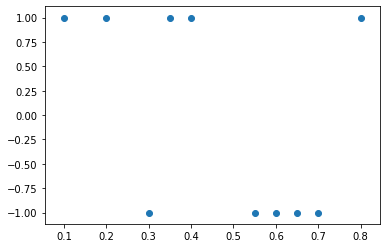

In [2]:
# Data set
S = [(0.1,1),(0.2,1),(0.3,-1),(0.35,1),(0.4,1),(0.55,-1),(0.6,-1),(0.65,-1),(0.7,-1),(0.8,1)]
#S = [(0.1,1),(0.2,1),(0.8,1)] #alternative training set

#vector with 1D features
xVec = [s[0] for s in S]
#vector with labels of the training data
yVec = [s[1] for s in S]
#plotting training data
plt.scatter(xVec, yVec)

#extended x and y Vectors which are fixed to 0 at the boundaries
xVecExtended = np.zeros(len(xVec)+2)
xVecExtended[1:-1]= xVec
xVecExtended[-1] = 1
yVecExtended = np.zeros(len(yVec)+2)
yVecExtended[1:-1]= yVec


# 1a)
Draw the individual hat functions

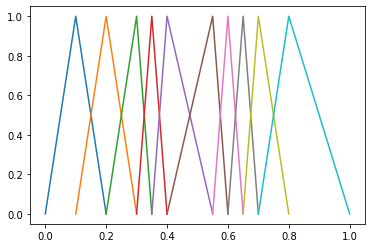

In [3]:
# Construct the hat functions for each interval
# For these we need to loo over all basis functions. Each one of these will need 3 points: one
# for the left border, one for the right border and one additional point somewhere in between. Store
# the appropiate x-coordinates in xHat and the y-coordinates in y-hat.
for i in range(len(xVec)): #loop over all basis functions
    # Left border
    if i == 0:
        x_1 = 0
    else:
        x_1 = xVec[i-1]
    # Right border
    if i == len(xVec)-1:
        x_3 = 1
    else:
        x_3 = xVec[i+1]
    xHat = [x_1,xVec[i],x_3]
    yHat = [0,1,0] # 0 at borders 1 at center

    # Plot hat
    plt.plot(xHat,yHat)

# 1b)
Datermine the coefficients of the basis functions and plot the resulting scaled hats + resulting function f_n(x)

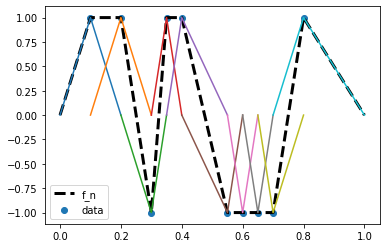

In [4]:
# Plot the training data
plt.scatter(xVec,yVec, label="data")

# Plot the resulting function. Remember that it will just be the linear interpolation of
# the extended points
plt.plot(xVecExtended,yVecExtended,color="black",label="f_n",linewidth=3,linestyle='--')

# Calculate the hat functions as before, but now scale them with the height v_i.
for i in range(len(xVec)):
    # Left border
    if i == 0:
        x_1 = 0
    else:
        x_1 = xVec[i-1]
    # Right border
    if i == len(xVec)-1:
        x_3 = 1
    else:
        x_3 = xVec[i+1]
    xHat = [x_1,xVec[i],x_3]
    yHat = [0,yVec[i],0] # 0 at borders, v_i at center

    # Plot hat
    plt.plot(xHat,yHat)
plt.legend()

# 1c)
We are now formally defining the hat functions and $$f_N(x) = \sum^N_{j=1} v_j \varphi_j(x) \approx f(x)$$ and evaluate it at 0.5

In [5]:
# Basis functions
def phi_int(i,x):
    if i == 0:
        x_1 = 0
    else:
        x_1 = xVec[i-1]
    if i == len(xVec)-1:
        x_3 = 1
    else:
        x_3 = xVec[i+1]
    if( x >= x_3 or x <= x_1):
        return 0
    if(x >= xVec[i]):
        h = x_3 - xVec[i]
        return (x_3 - x)/h
    else:
        h = xVec[i] - x_1
        return (x - x_1)/h

# f_n
def f_n_inter(x):
    result = 0.0
    for i in range(len(xVec)):
        result += yVec[i]* phi_int(i,x)
    return result

#evaluate f_n at 0.5
print(f_n_inter(0.5))

-0.3333333333333328


# Exercise 2: Equidistant nodal basis

# 2a)
Calculate the matrix G where G_ij = phi_j(x_i) and x_i are the feature values of the training set (from xVec)

In [6]:
# Number of basis functions
n = 3
# Create equidistant points x_0 to x_n+1 for hat functions
xVecHat = np.linspace(0,1,n+2)

# Basis functions for equidistant grid
def phi_nodal(n,i,x):
    h = 1.0/(n+1)
    if( x >= xVecHat[i+1]+ h  or x <= xVecHat[i+1] - h):
        return 0
    if(x > xVecHat[i+1]):
        return (xVecHat[i+2] - x)/h
    else:
        return (x - xVecHat[i])/h

G = np.matrix(np.zeros((len(xVec),n)))
# Fill matrix G. Remember that G_ij = phi_j(x_i), where x_i are the feature values of the
# training set (from xVec)
for i in range(len(xVec)):
    for j in range(n):
        G[i,j] = phi_nodal(n,j,xVec[i])
print(G)

[[0.4 0.  0. ]
 [0.8 0.  0. ]
 [0.8 0.2 0. ]
 [0.6 0.4 0. ]
 [0.4 0.6 0. ]
 [0.  0.8 0.2]
 [0.  0.6 0.4]
 [0.  0.4 0.6]
 [0.  0.2 0.8]
 [0.  0.  0.8]]


# 2b)
Solve the least squares problem ($G^T G v = G^T y$) using the normal equation + solving of resulting

In [7]:
print("G^T * G:")
print(G.T * G)
print("G^T * y:")
print(G.T * np.matrix(yVec).T)
# Solve the least squares problem using the normal equations and save the result in v_nodal.
# Remember that you can solve the linear system Ax = b with via x = np.linalg.solve(A, b)
v_nodal = np.linalg.solve(G.T * G,  G.T * np.matrix(yVec).T)
print("v:")
print(v_nodal)


G^T * G:
[[1.96 0.64 0.  ]
 [0.64 1.76 0.8 ]
 [0.   0.8  1.84]]
G^T * y:
[[ 1.4]
 [-1.2]
 [-1.2]]
v:
[[ 1.02241888]
 [-0.94365782]
 [-0.24188791]]


# 2c)
Calculate the final approximation $f_N(x)$ that results from $$f_N(x) = \sum^N_{j=1} v_j \varphi_j(x) \approx f(x)$$ and evaluate at 0.5

-0.9436578171091444


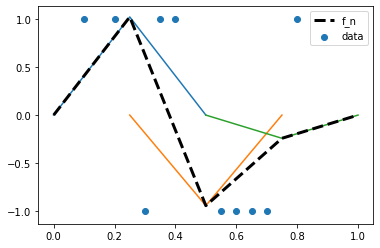

In [8]:
# f_n
def f_n_nodal(x):
    result = 0.0
    for i in range(n):
        result += v_nodal[i]* phi_nodal(n,i,x)
    return float(result)

# Evaluate f_n_nodal at 0.5
print(f_n_nodal(0.5))

# Define and plot all the scaled hat functions
for i in range(n):
    h = 1.0/(n+1)
    xHat = [xVecHat[i+1]- h, xVecHat[i+1], xVecHat[i+1]+h]
    yHat = [0,v_nodal[i],0]
    plt.plot(xHat,yHat)

# Plot f_n
temp = np.zeros(n+2)
temp[1:-1] = np.array(v_nodal).flatten()
plt.plot(xVecHat, temp, color="black", label="f_n",linewidth=3,linestyle='--')
plt.scatter(xVec,yVec, label="data")
plt.legend()
plt.show()


# Exercise 3: Hierarchical classification

Do the same as in Exercise 2 with Hierarchical Clustering.

In [9]:
import math
# Number of basis functions. It has to be 2^k - 1 for some integer k!
n = 3
numlevel=int(math.log(n+1,2)) #calculate the number of levels
print("Number of levels: ",numlevel)

#basis functions for hierarchical approximation
def phi_hier(level,i,x):
    h = 1.0/(2**level)
    xLevel = np.linspace(0,1,2**level+1)
    i=2*(i+1)-1 #only odd basis functions
    if( x >= xLevel[i]+ h  or x <= xLevel[i] - h):
        return 0
    if(x >= xLevel[i]):
        return (xLevel[i+1] - x)/h
    else:
        return (x - xLevel[i-1])/h

G = np.matrix(np.zeros((len(xVec),n)))
# Fill G with correct values
for i in range(len(xVec)):
    j=0
    for l in range(numlevel):
        for jLevel in range(2**l):
            G[i,j] = phi_hier(l+1,jLevel,xVec[i])
            j += 1

print(G)

Number of levels:  2
[[0.2 0.4 0. ]
 [0.4 0.8 0. ]
 [0.6 0.8 0. ]
 [0.7 0.6 0. ]
 [0.8 0.4 0. ]
 [0.9 0.  0.2]
 [0.8 0.  0.4]
 [0.7 0.  0.6]
 [0.6 0.  0.8]
 [0.4 0.  0.8]]


In [10]:
print("G^T * G:")
print(G.T * G)
print("G^T * y:")
print(G.T * np.matrix(yVec).T)
# Solve the least squares problem using the normal equations and save the result in v_hier
# Remember that you can solve the linear system Ax = b with via x = np.linalg.solve(A, b)
v_hier = np.linalg.solve(G.T * G,  G.T * np.matrix(yVec).T)
print("v:")
print(v_hier)

G^T * G:
[[4.15 1.62 1.72]
 [1.62 1.96 0.  ]
 [1.72 0.   1.84]]
G^T * y:
[[-1.1]
 [ 1.4]
 [-1.2]]
v:
[[-0.94365782]
 [ 1.49424779]
 [ 0.229941  ]]


2
-0.943657817109144


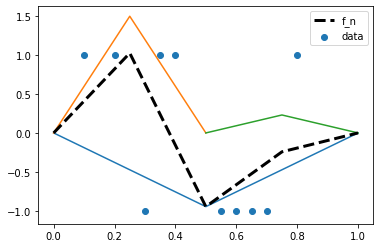

In [11]:
print(numlevel)
# f_n.
def f_n_hier(x):
    result = 0.0
    j = 0
    for l in range(numlevel):
        for jLevel in range(2**l):
            result += v_hier[j]* phi_hier(l+1,jLevel,x)
            j += 1
    return float(result)

# Evaluate f_n_hier at 0.5
print(f_n_hier(0.5))
# Define and plot all the scaled hat functions
j = 0
for l in range(numlevel):
    for jLevel in range(2**l):
        jLevel = 2*(jLevel+1) -1 #only odd values
        h = 1.0/(2**(l+1))
        xLevel = np.linspace(0,1,2**(l+1)+1)
        xHat = [xLevel[jLevel]- h, xLevel[jLevel], xLevel[jLevel]+h]
        yHat = [0,v_hier[j],0]
        plt.plot(xHat,yHat)
        j += 1

# Plot f_n_hier
temp = np.zeros(n+2)
temp[1:-1] = np.array(v_hier).flatten()
y_hier = [float(f_n_hier(x)) for x in xVecHat]
plt.plot(xVecHat, y_hier, color="black",label="f_n",linewidth=3,linestyle='--')
plt.scatter(xVec,yVec, label="data")
plt.legend()
